/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:07<00:00, 73.6MB/s]


Step 50/500, Total Loss: 179797120.0
Step 100/500, Total Loss: 128057576.0
Step 150/500, Total Loss: 103645888.0
Step 200/500, Total Loss: 88555088.0
Step 250/500, Total Loss: 78120320.0
Step 300/500, Total Loss: 70306920.0
Step 350/500, Total Loss: 64063512.0
Step 400/500, Total Loss: 58855948.0
Step 450/500, Total Loss: 54397536.0


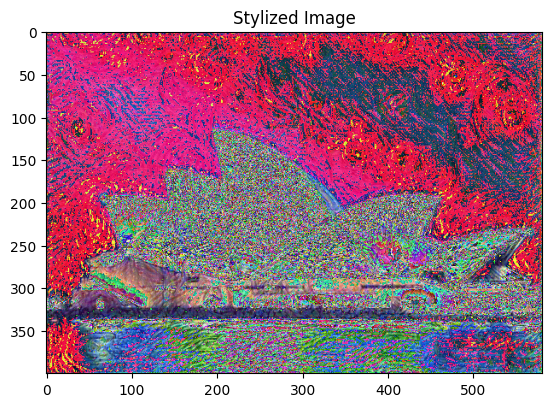

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from PIL import Image
import matplotlib.pyplot as plt

# Load image function
def load_image(img_path, max_size=400, shape=None):
    image = Image.open(img_path).convert('RGB')

    # Resize image
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)

    if shape:
        size = shape

    transform = transforms.Compose([
        transforms.Resize(size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])])

    image = transform(image)[:3, :, :].unsqueeze(0)
    return image

# Display image function
def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = transforms.ToPILImage()(image)

    plt.imshow(image)
    if title:
        plt.title(title)
    plt.show()

# Load content and style images
content_img_path = "content.jpg"  # Path to content image
style_img_path = "style.jpg"      # Path to style image

content = load_image(content_img_path).to("cuda" if torch.cuda.is_available() else "cpu")
style = load_image(style_img_path, shape=[content.size(2), content.size(3)]).to("cuda" if torch.cuda.is_available() else "cpu")

# Define model and loss
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.chosen_features = ["0", "5", "10", "19", "28"]
        self.model = models.vgg19(pretrained=True).features[:29]

    def forward(self, x):
        features = []
        for layer_num, layer in enumerate(self.model):
            x = layer(x)
            if str(layer_num) in self.chosen_features:
                features.append(x)
        return features

# Compute gram matrix for style loss
def gram_matrix(tensor):
    _, c, h, w = tensor.size()
    tensor = tensor.view(c, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram

# Style Transfer Implementation
def style_transfer(content, style, model, num_steps=500, style_weight=1e6, content_weight=1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initialize target image
    target = content.clone().requires_grad_(True).to(device)

    # Optimizer
    optimizer = optim.Adam([target], lr=0.003)

    for step in range(num_steps):
        target_features = model(target)
        content_features = model(content)
        style_features = model(style)

        # Compute content loss
        content_loss = torch.mean((target_features[2] - content_features[2]) ** 2)

        # Compute style loss
        style_loss = 0
        for tf, sf in zip(target_features, style_features):
            _, c, h, w = tf.size()
            target_gram = gram_matrix(tf)
            style_gram = gram_matrix(sf)
            style_loss += torch.mean((target_gram - style_gram) ** 2) / (c * h * w)

        # Total loss
        total_loss = style_weight * style_loss + content_weight * content_loss

        # Update target image
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if step % 50 == 0:
            print(f"Step {step}/{num_steps}, Total Loss: {total_loss.item()}")

    return target

# Perform style transfer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VGG().to(device).eval()

output = style_transfer(content, style, model)
imshow(output, title="Stylized Image")
